In [4]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from wfOpto import *
from matplotlib.patches import Rectangle
import warnings
from scipy.ndimage import gaussian_filter1d
warnings.filterwarnings("ignore")


print('done')

done


In [5]:
print('bro')

bro


### importing

In [6]:
dataVis=wfOpto((Path(r'Z:\Subjects\AL_0023\2023-08-24\1')))
#this is a test comment 

In [7]:
dataOp = wfOpto(Path(r'Z:\Subjects\ZYE_0069\2023-08-16\1'))

In [84]:
data830 = wfOpto((Path(r'Z:\Subjects\AL_0023\2023-08-30\1')), listExps=[np.r_[:1350], np.r_[1350:1800]])

In [8]:
# process 830
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (dataVis.py, dataVis.px))
pows = np.argwhere(dataVis.laserPowers[dataVis.listExps[0]] == power).ravel()
onTimes = dataVis.laserOn[dataVis.listExps[0]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataVis.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVis.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

### figure 1

- the technique works via viral injection of opsin + gcamp.
- we can track brain activity against stimulus using WF and it corresponds with ephys results. 
- we can make pretty images of the brain that correspond to the pixel values we use in analysis.

#### panels

In [68]:
def brainImg(ax):
    '''
    '''
    pows = np.argwhere(dataOp.laserPowers==1).ravel()
    theseTrs=np.intersect1d(pows,galvoY)
    trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
    trial_activity_all = dataOp.tToWf(trial_time_all)
    trial_activity_all = np.mean(trial_activity_all, axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)
    
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1)
    videoAvg = np.mean(videoAvg, axis=2)
    plt.imshow(videoAvg, cmap='bwr')


In [76]:
def inactivation(ax):
    plt.title('basic power:inactivation graph')


In [54]:
def microscope(ax):
    '''
    shows pulse length and magnitude
    pulse length - .1 s
    magnitude is 2.5 
    '''
    plt.title('microscope')
def geneExpression(ax):
    '''
    shows pulse length and magnitude
    pulse length - .1 s
    magnitude is 2.5 
    '''
    plt.title('gene expression')


In [51]:
def wfTrace(ax):
    power = 1
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    galvoLoc=0

    pixel_ix=np.ravel_multi_index((428,410),(dataOp.py, dataOp.px))
    pows = np.argwhere(dataOp.laserPowers==power).ravel()
    galvoY = np.argwhere(dataOp.galvoY==galvoLoc).ravel()
    theseTrs=np.intersect1d(pows,galvoY)
    onTimes=dataOp.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPower=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        mov=dataOp.svdSpat[pixel_ix]@dwf
        thisPower.append(mov)
    thisPower=np.array(thisPower)
    plt.plot(timestamps,np.mean(thisPower,axis=0))
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.title(f'power={power} yLoc={galvoLoc} xLoc={0} One Pixel')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [144]:
def ephys(ax):
    t = np.linspace(-0.3, 1, 650)  
    frequency = 1 
    amplitude = 1
    phase_shift = 0
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t + phase_shift)
    plt.plot(t, sine_wave)
    plt.xlabel('Time (s)')
    plt.ylabel('activity')
    plt.title('Ephys activity for 1.5mW bottom left')


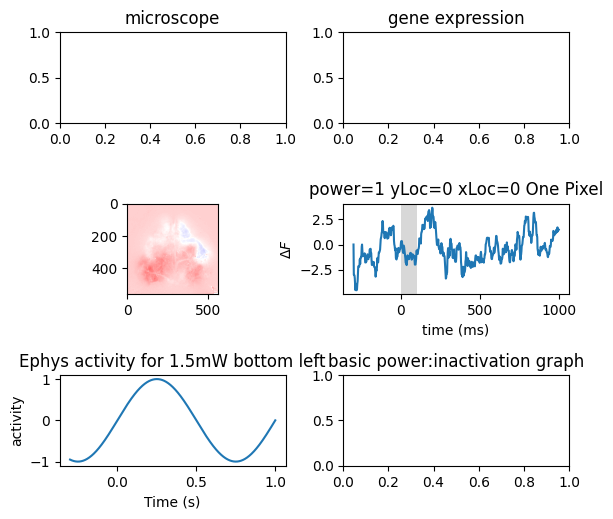

In [145]:
# figure plotting

f = plt.figure(figsize=(6,10))
gs=mpl.gridspec.GridSpec(6,2)

ax = plt.subplot(gs[0])
microscope(ax)

ax = plt.subplot(gs[1])
geneExpression(ax)

ax = plt.subplot(gs[2])
brainImg(ax)

ax = plt.subplot(gs[3])
wfTrace(ax)

ax = plt.subplot(gs[4])
ephys(ax)

ax = plt.subplot(gs[5])
inactivation(ax)

f.tight_layout()

### figure 2

- In control mice (no opsin) red laser at certain powers and locations evokes response in visual cortex. 
- The magnitude of the visual response is reduced by adapting the retina with flicker. 
- There exists a range of laser powers that inactive neurons while not evoking a detectable visual response. 
- Light intensities used for fluorescence imaging do not drive opsin. 


In [104]:
def controlBrain(ax):
    '''
    img of the brain of the brain of the control mouse. shows where stimulation happens (retina and VC)
    '''
    pows = np.argwhere(dataVis.laserPowers==1).ravel()
    galvoY=np.argwhere(dataVis.galvoY==0)
    theseTrs=np.intersect1d(pows,galvoY)
    trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
    trial_activity_all = dataVis.tToWf(trial_time_all)
    trial_activity_all = np.mean(trial_activity_all, axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)
    
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1)
    videoAvg = np.mean(videoAvg, axis=2)
    plt.imshow(videoAvg, cmap='bwr')

In [86]:
def activityStim(ax):
    '''
    in a control mouse - activity in the VC when stimulating retina and when stimulating VC
    using power 2
    pixel - 150,450 lower left 
    '''
    power = np.squeeze(np.argwhere(dataVis.laserPowers==1))
    locTop = np.squeeze(np.argwhere(dataVis.galvoY==0))
    locBot = np.squeeze(np.argwhere(dataVis.galvoY==2.5))
    n_samples=650
    
    #stim retina
    indexRetina = np.intersect1d(power,locTop) #stimulation indeces - power, location top for retina
    pixel_ixRetina = np.ravel_multi_index((450,150),(dataVis.px,dataVis.py)) #what pixel to track, lower left
    onTimes = dataVis.laserOn[indexRetina] #get all the laser ons for the indeces
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes] 
    trs = np.squeeze(np.array(trs))
    responseRet=[] 
    for iT, tr in enumerate(trs):
        wf = dataVis.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataVis.svdSpat[pixel_ixRetina] @ dwf
        responseRet.append(mov)
    responseRet = np.array(responseRet)
    
    #stim VC
    indexVC = np.intersect1d(power,locBot) #stimulation indeces - power, location bottom for vc
    pixel_ixVC = np.ravel_multi_index((450,150),(dataVis.py,dataVis.px))
    onTimes = dataVis.laserOn[indexVC]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    responseVC=[]
    for iT, tr in enumerate(trs):
        wf = dataVis.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataVis.svdSpat[pixel_ixVC] @ dwf
        responseVC.append(mov)
    responseVC = np.array(responseVC)

    plt.plot(timestamps, np.mean(responseRet, axis=0),label='Stim Retina',color='orange')
    plt.plot(timestamps, np.mean(responseVC, axis=0), label='Stim VC', color='green')
    plt.legend(fontsize=7)
    plt.xlabel('time (ms)',fontsize=7)
    plt.ylabel('$\Delta F$',fontsize=7)
    plt.title('(Control Mouse) Visual Response',fontsize=10)

In [87]:
def powActivity(ax):
    powers = np.unique(dataVis.laserPowers)
    pxPowersRetina=[]
    pxPowersVC=[]
    n_samples=650

    pixel_ix= np.ravel_multi_index((450,150),(dataVis.px,dataVis.py))

    trsRetina = np.argwhere(dataVis.galvoY==0).ravel()
    trsVC = np.argwhere(dataVis.galvoY==2.5).ravel()

    for iP, power in enumerate(powers):
        if power >= 0:
            trsPower = np.argwhere(dataVis.laserPowers==power).ravel()
            
            #retina
            onTimesRetina = np.intersect1d(trsRetina,trsPower)
            theseTrsRet = [np.linspace(on+-.3,on+1,n_samples) for on in onTimesRetina]
            theseTrsRet = np.squeeze(np.array(theseTrsRet))
            thisPowerRetina=[]
            for iT, tr in enumerate(theseTrsRet):
                wf=dataVis.tToWFManual(tr)
                dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = dataVis.svdSpat[pixel_ix] @ dwf
                thisPowerRetina.append(mov)
            thisPowerRetina = np.array(thisPowerRetina)
            pxPowersRetina.append(thisPowerRetina)

            #VC
            onTimesVC = np.intersect1d(trsVC, trsPower)
            theseTrsVC = [np.linspace(on+-.3,on+1,n_samples) for on in onTimesVC]
            theseTrsVC = np.squeeze(np.array(theseTrsVC))
            thisPowerVC=[]
            for iT, tr in enumerate(theseTrsVC):
                wf=dataVis.tToWFManual(tr)
                dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = dataVis.svdSpat[pixel_ix] @ dwf
                thisPowerVC.append(mov)
            thisPowerVC = np.array(thisPowerVC)
            pxPowersVC.append(thisPowerVC)
    retinaInt=[]
    time=np.linspace(-.3,1,650)
    for count,pxPowers in enumerate(pxPowersRetina):
        pxPowers = np.mean(pxPowers,axis=0)
        min=np.min(pxPowers)
        pxPowers=pxPowers+(min*-1)
        int=np.trapz(y=pxPowers)
        retinaInt.append(int)
    retinaInt = np.array(retinaInt)

    vcInt=[]
    for count,pxPowers in enumerate(pxPowersVC):
        pxPowers = np.mean(pxPowers,axis=0)
        min=np.min(pxPowers)
        pxPowers=pxPowers+(min*-1)
        int=np.trapz(y=pxPowers)
        vcInt.append(int)
    vcInt = np.array(vcInt)

    dotkwargs={'marker':'.', 'yerr':0}
    constant=100

    plt.errorbar(np.unique(dataVis.laserPowers),retinaInt/constant,c='green',label='stim retina',**dotkwargs)
    plt.errorbar(np.unique(dataVis.laserPowers),vcInt/constant,c='orange',label='stim VC',**dotkwargs)
    plt.legend(fontsize=7)
    plt.xlabel('Optogenetic Laser Power mW',fontsize=7)
    plt.ylabel('Visual Response',fontsize=7)     
    plt.title('Magnitude of Visual Response',fontsize=10)            
    

In [88]:
def visResp(ax):
    pixel = (410, 428)
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    pows = np.argwhere(data830.laserPowers[data830.listExps[1]] == power).ravel()
    onTimes = data830.laserOn[data830.listExps[1]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    noFlicker = []
    for iT, tr in enumerate(trs):
        wf = data830.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = data830.svdSpat[pixel_ix] @ dwf
        noFlicker.append(mov)
    noFlicker = np.array(noFlicker)
    # plt.plot(timestamps, np.mean(noFlicker, axis=0))
    # plt.title(f'power {power}')
    # plt.xlabel('time (ms)')
    # plt.ylabel('$\Delta F$')
    colors = ['forestgreen', 'darkorange']
    plt.plot(timestamps, np.mean(noFlicker, axis=0), color=colors[0], label='without flicker')
    plt.fill_between(timestamps, \
                     np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                     np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color=colors[0], alpha=0.3, lw=0, label='_nolegend_')
    
    plt.plot(timestamps, np.mean(flicker,axis=0),color=colors[1], label='with flicker')
    plt.fill_between(timestamps, \
                     np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                     np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color=colors[1], lw=0, label='_nolegend_', alpha=0.3)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.legend(fontsize=7)
    plt.ylim(None, 30)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset(s)',fontsize=7)
    plt.ylabel('Visual response',fontsize=7)
    plt.title(f'{power} mW opto stim',fontsize=10)

In [89]:
def adaptResp(ax):
    powers = np.unique(data830.laserPowers)
    pixel = (410, 428)
    pxPowersFlicker = [] 
    pxPowersNoFlicker = []
    n_samples = 650
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    for iP, power in enumerate(powers):
        if power >= 0:
            theseTrsFlicker = np.argwhere(data830.laserPowers[data830.listExps[0]]== power).ravel()
            # theseTrsFlicker=theseTrsFlicker[::3]
            onTimesFlicker = data830.laserOn[data830.listExps[0]][theseTrsFlicker]
            trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
            trsFlicker = np.squeeze(np.array(trsFlicker))
            
            theseTrsNFlicker = np.argwhere(data830.laserPowers[data830.listExps[1]]== power).ravel()
            onTimesNFlicker = data830.laserOn[data830.listExps[1]][theseTrsNFlicker]
            trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
            trsNFlicker = np.squeeze(np.array(trsNFlicker))
            
            thisPowerNFlicker = []
            thisPowerFlicker = []
            for iT, tr in enumerate(trsFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerFlicker.append(mov)
            thisPowerFlicker = np.array(thisPowerFlicker)
            pxPowersFlicker.append(thisPowerFlicker)
    
            for iT, tr in enumerate(trsNFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerNFlicker.append(mov)
            thisPowerNFlicker = np.array(thisPowerNFlicker)
            pxPowersNoFlicker.append(thisPowerNFlicker)   
    
    flickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        flickInt.append(int)
    flickInt = np.array(flickInt)
    
    noflickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersNoFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        noflickInt.append(int)
    noflickInt = np.array(noflickInt)
    # plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')

    dotkwargs = {'marker': '.', 'yerr': 0}
    constant = 100
    plt.errorbar(np.unique(data830.laserPowers), noflickInt/constant, c='forestgreen', label='without flicker', **dotkwargs)
    
    # plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
    plt.errorbar(np.unique(data830.laserPowers), flickInt/constant, c='darkorange', label='with flicker', **dotkwargs)
    
    plt.legend(fontsize=7)
    plt.xlabel('Optogenetic laser power (mW)',fontsize=7)
    plt.ylabel('Visual response',fontsize=7)
    plt.title('Magnitude of Visual Response',fontsize=10)

In [106]:
def opsinLight(ax):
    plt.title('Opsin light doesnt drive gcamp')

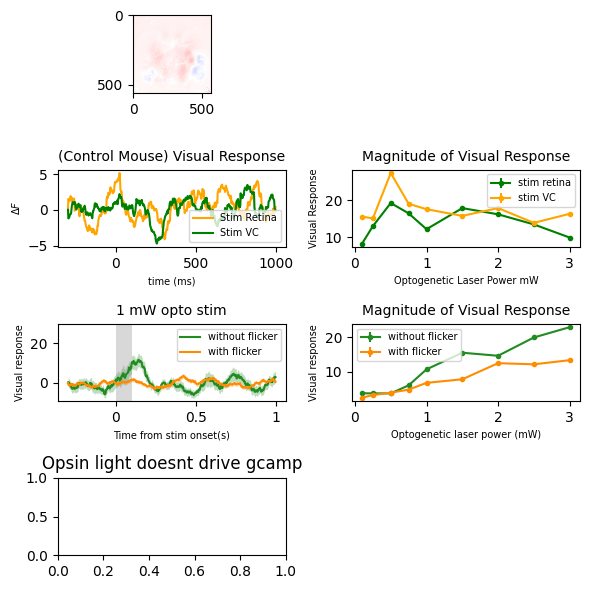

In [109]:
# figure plotting

f = plt.figure(figsize=(6,15))
gs=mpl.gridspec.GridSpec(10,2)

ax = plt.subplot(gs[0])
controlBrain(ax)

ax = plt.subplot(gs[2])
activityStim(ax)

ax = plt.subplot(gs[3])
powActivity(ax)

ax = plt.subplot(gs[4])
visResp(ax)

ax = plt.subplot(gs[5])
adaptResp(ax)

ax = plt.subplot(gs[6])
opsinLight(ax)

f.tight_layout()

### figure 3

- there is temporal spread
- there is spatial spread
- spread and activation depends on power 
- it is consistent over months 

tbd:
- with flicker
- day-to-day

In [133]:
def temporalRes(ax):
    '''
    temportal resolution across powers
    '''
    powers = np.unique(dataOp.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp.py, dataOp.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp.laserPowers == power).ravel()
        onTimes = dataOp.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for iP in pxPowers:
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0))
        # plt.legend(['.1', '.2', '.5', '.7', '1.0', '1.2', '1.5', '1.7', '2.0'], loc='right')
        plt.axvline(x=90)
        plt.xlabel('time (ms)')
        plt.ylabel('$\Delta F$')
        plt.title('temporal resolution')


In [134]:
def temportalQuant(ax):
    '''
    quantification of temporal spread. half width?
    '''
    plt.title('quantification of temporal spread')


In [146]:
def spatialRes(ax):
    '''
    spatial resolution
    how to do this? along lines or do an ROI?
    '''
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power)) # find trials
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

        activity = dataOp.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
        
        activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
        dwf = np.array(dwf)
        avg = np.mean(dwf, axis=1)
        
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
        # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
        videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
        videoROI = videoAvg[250, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)

    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        data = spreadByPower[count]
        data = gaussian_filter1d(data, sigma=2)
        plt.plot(data,c='k') 
    # plt.title("Spatial spread over horizontal line")
    plt.xlabel("location 560:560")
    plt.ylabel("activity")

    plt.title('spatial resolution')


In [136]:
def spatialQuant(ax):
    '''
    quantifying spatial resolution. also half-width?
    '''
    plt.title('quantification ofspatial resolution')


In [137]:
def powerDep(ax):
    '''
    how power impacts inactivation
    '''
    powers = np.unique(dataOp.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp.py, dataOp.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp.laserPowers == power).ravel()
        onTimes = dataOp.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k')
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.xlabel("powers")
    plt.ylabel("inhibition")
    plt.title("effect at peak (90 ms)")



In [149]:
def activityPast(ax):
    '''
    how activity was looking 6mo ago
    simple trace
    '''
    plt.title('trace from 6mo ago')


In [150]:
def activityPresent(ax):
    '''
    how it is looking 6mo after
    simple trace
    '''
    plt.title('trace 6mo later')


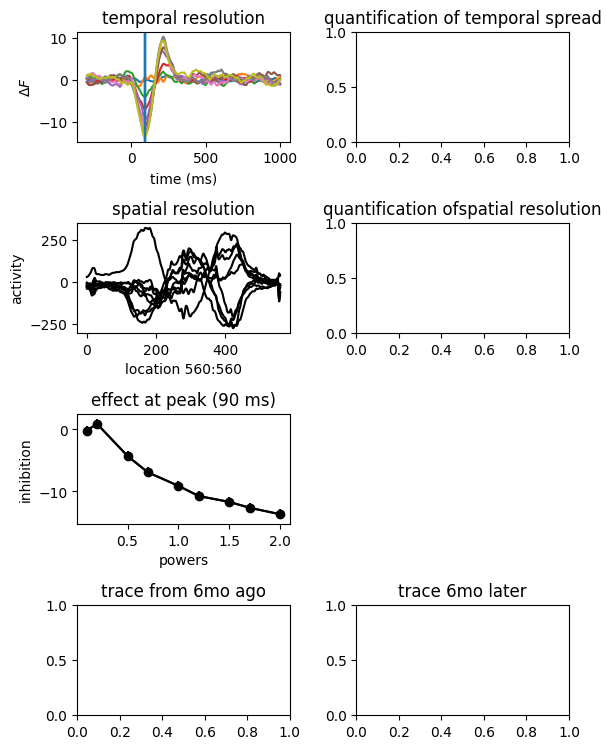

In [151]:
# figure plotting

f = plt.figure(figsize=(6,15))
gs=mpl.gridspec.GridSpec(8,2)

ax = plt.subplot(gs[0])
temporalRes(ax)

ax = plt.subplot(gs[1])
temportalQuant(ax)

ax = plt.subplot(gs[2])
spatialRes(ax)

ax = plt.subplot(gs[3])
spatialQuant(ax)

ax = plt.subplot(gs[4])
powerDep(ax)

ax = plt.subplot(gs[6])
activityPast(ax)

ax = plt.subplot(gs[7])
activityPresent(ax)

f.tight_layout()

### figure 4

- activity in the left doesnt predict the right and vice versa

In [ ]:
f = plt.figure(figsize=(6,6))
gs=mpl.gridspec.GridSpec(2,2)

# ax = plt.subplot(gs[0])
# imgLeft(ax)

# ax = plt.subplot(gs[1])
# quantLeft(ax)

# ax = plt.subplot(gs[2])
# imgRight(ax)

# ax = plt.subplot(gs[3])
# quantRight(ax)